In [ ]:
!pip install transformers
!pip install torch
!pip install speechrecognition

In [ ]:
!pip install pydub

In [ ]:
!pip install openai-whisper
!pip install transformers torch torchvision opencv-python matplotlib pillow
!pip install -U transformers huggingface-hub lz4 mtcnn opencv-python pillow torch matplotlib



In [ ]:
import os
import cv2
import librosa
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
import speech_recognition as sr
from transformers import (AutoProcessor, AutoModelForImageClassification,
                          AutoTokenizer, AutoModelForSequenceClassification, pipeline)
from PIL import Image
from moviepy.editor import VideoFileClip
from collections import Counter

  if event.key is 'enter':



In [ ]:
import os
import mimetypes
import cv2
import torch
import torch.nn.functional as F
from transformers import (
    AutoFeatureExtractor, AutoModelForImageClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    pipeline
)
from PIL import Image
import numpy as np
import speech_recognition as sr
import matplotlib.pyplot as plt

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt

In [ ]:
!pip install moviepy numpy


# model for image

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Predicted Emotion: angry

Emotion Probabilities:
angry: 0.940
disgust: 0.001
fear: 0.049
happy: 0.003
neutral: 0.002
sad: 0.002
surprise: 0.003


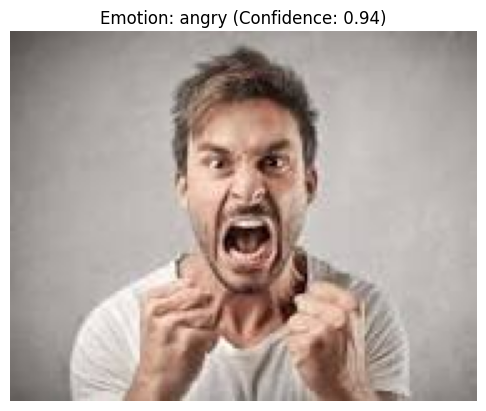

In [ ]:
def predict_emotion_from_image(image_path):
    model_name = "trpakov/vit-face-expression"
    processor = AutoProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(model_name)

    image = Image.open(image_path).convert("RGB")


    inputs = processor(images=image, return_tensors="pt")


    with torch.no_grad():
        logits = model(**inputs).logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]

    predicted_class = torch.argmax(probabilities).item()

    emotion_label = model.config.id2label[predicted_class]


    print(f"Predicted Emotion: {emotion_label}")
    print("\nEmotion Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{model.config.id2label[i]}: {prob.item():.3f}")

    plt.imshow(image)
    plt.title(f"Emotion: {emotion_label} (Confidence: {probabilities[predicted_class]:.2f})")
    plt.axis('off')
    plt.show()


# image_path = '/content/test_image1.jpeg'
# predict_emotion_from_image(image_path)

# model for video model

In [ ]:
def predict_emotion_from_video(video_path, frame_interval=30):

    detector = MTCNN()


    model_name = "trpakov/vit-face-expression"
    extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(model_name)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    def extract_face_frames(video_path, frame_interval):
        cap = cv2.VideoCapture(video_path)
        frames_with_faces = []
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if frame_count % frame_interval == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                result = detector.detect_faces(frame_rgb)

                if len(result) > 0:
                    pil_img = Image.fromarray(frame_rgb)
                    frames_with_faces.append(pil_img)

            frame_count += 1

        cap.release()
        print(f"✅ Total frames with faces detected: {len(frames_with_faces)}")
        return frames_with_faces


    def predict_emotion(image):
        inputs = extractor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            logits = model(**inputs).logits
            probabilities = F.softmax(logits, dim=1)[0]

        predicted_class = torch.argmax(probabilities).item()
        label = model.config.id2label[predicted_class]
        return label, probabilities.cpu().numpy()


    frames = extract_face_frames(video_path, frame_interval)

    if len(frames) == 0:
        print("❌ No faces found in video.")
        return

    emotion_counts = Counter()
    all_probabilities = []

    for img in frames:
        label, probs = predict_emotion(img)
        emotion_counts[label] += 1
        all_probabilities.append(probs)


    avg_probs = np.mean(all_probabilities, axis=0)
    labels = list(model.config.id2label.values())


    plt.figure(figsize=(10, 5))
    plt.bar(labels, avg_probs, color='skyblue')
    plt.title("Average Emotion Probabilities Over Video")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    most_common_emotion = emotion_counts.most_common(1)[0]
    print(f"\n🎭 Overall Detected Emotion: {most_common_emotion[0]} ({most_common_emotion[1]} frames)")



In [ ]:

# video_path = "sample_video2.mp4"

# predict_emotion_from_video("sample_video2.mp4")

# audio model

In [ ]:
import speech_recognition as sr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

def predict_emotion_from_audio(audio_path):

    def extract_text_from_audio(audio_file_path):
        recognizer = sr.Recognizer()

        with sr.AudioFile(audio_file_path) as source:
            print("🔊 Extracting audio from file...")
            audio_data = recognizer.record(source)

        try:
            print("📝 Recognizing speech...")
            text = recognizer.recognize_google(audio_data)
            print("✅ Text extracted successfully.")
            print(f"\n📝 Extracted Text: {text}\n")
        except sr.UnknownValueError:
            print("❌ Could not understand the audio.")
            text = None
        except sr.RequestError:
            print("❌ Could not request results from the Google API.")
            text = None

        return text

    def predict_emotion_from_text(text):
        if text is None:
            return "No text extracted to predict emotion.", 0.0

        model_name = "j-hartmann/emotion-english-distilroberta-base"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name)

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = F.softmax(logits, dim=-1)
        predicted_class_id = int(torch.argmax(probs, dim=-1))
        confidence = float(probs[0][predicted_class_id])

        id2label = model.config.id2label
        predicted_emotion = id2label[predicted_class_id]

        return predicted_emotion, confidence


    text = extract_text_from_audio(audio_path)
    if text:
        emotion, confidence = predict_emotion_from_text(text)
        print(f"🎭 Predicted Emotion: {emotion} (Confidence: {confidence*100:.2f}%)")
    else:
        print("❌ No text available for emotion prediction.")


In [ ]:
def extract_audio_from_video(video_path, output_audio_path="extracted_audio.wav"):
    try:

        video_clip = VideoFileClip(video_path)


        if video_clip.audio is None:
            print("❌ No audio stream found in this video.")
            return False


        video_clip.audio.write_audiofile(output_audio_path)
        print(f"✅ Audio extracted and saved as {output_audio_path}")


        if os.path.getsize(output_audio_path) == 0:
            print("❌ Extracted audio file is empty.")
            return False


        audio_array = video_clip.audio.to_soundarray()
        if np.all(audio_array == 0):
            print("❌ Audio track is silent (all zero samples).")
            return False

        print("✅ Audio track contains sound.")
        return True

    except Exception as e:
        print(f"❌ Error extracting audio: {e}")
        return False



In [ ]:
#predict_emotion_from_audio("/content/harvard.wav")

# text model

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "j-hartmann/emotion-english-distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)


text_model_name = "j-hartmann/emotion-english-distilroberta-base"
text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModelForSequenceClassification.from_pretrained(text_model_name)
text_pipeline = pipeline("text-classification", model=text_model, tokenizer=text_tokenizer)
def extract_text_from_audio(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
    try:
        return recognizer.recognize_google(audio_data)
    except Exception as e:
        print(f"Speech recognition error: {e}")
        return None
def predict_emotion_from_text(text):
    result = text_pipeline(text)
    return result[0]['label'], result[0]['score']

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import speech_recognition as sr

def extract_text_from_audio(audio_path):
    recognizer = sr.Recognizer()

    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)

        text = recognizer.recognize_google(audio_data)
        print(f"📝 Extracted Text: {text}")
        return text

    except sr.UnknownValueError:
        print("❌ Could not understand audio.")
        return None
    except sr.RequestError as e:
        print(f"❌ Error with the speech recognition service: {e}")
        return None
    except Exception as e:
        print(f"❌ Error processing audio: {e}")
        return None


In [ ]:
#predict_emotion_from_text('the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun')

In [ ]:
!pip install mtcnn

# preprocessing

In [ ]:
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import string
import nltk
import random
import torch
from torchvision import models, transforms
from pydub import AudioSegment
import speech_recognition as sr
from moviepy.editor import VideoFileClip
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

# ================= VIDEO PREPROCESSING =================
def preprocess_video(video_path):
    print(f"\n=== Video Preprocessing: {video_path} ===")
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frame = frame.astype(np.float32) / 255.0
        frame = cv2.GaussianBlur(frame, (5, 5), 0)
        frames.append(frame)
        frame_count += 1
    cap.release()
    print(f"Extracted and preprocessed {frame_count} frames.")

    if frame_count > 0:

        idx = random.randint(0, frame_count-1)
        plt.imshow(frames[idx])
        plt.title(f"Sample Preprocessed Frame #{idx+1}")
        plt.axis('off')
        plt.show()


    try:
        video_clip = VideoFileClip(video_path)
        if video_clip.audio is None:
            print("No audio track detected in video.")
        else:
            audio_path = "temp_audio.wav"
            video_clip.audio.write_audiofile(audio_path, verbose=False, logger=None)
            preprocess_audio(audio_path)
            os.remove(audio_path)
    except Exception as e:
        print(f"Error extracting audio: {e}")

# ================= AUDIO PREPROCESSING =================
def preprocess_audio(audio_path):
    print(f"\n=== Audio Preprocessing: {audio_path} ===")
    audio, sample_rate = librosa.load(audio_path, sr=None)
    print(f"Audio loaded: Sample rate = {sample_rate}, shape = {audio.shape}")

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    print(f"MFCCs shape: {mfccs.shape}")
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

    # Mel Spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=8000)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    print(f"Spectrogram shape: {log_spectrogram.shape}")
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    # Speech-to-Text
    recognizer = sr.Recognizer()
    try:
        audio_file = AudioSegment.from_file(audio_path)
        wav_path = "temp.wav"
        audio_file.export(wav_path, format="wav")
        with sr.AudioFile(wav_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
            print("\nSpeech-to-Text Transcription:")
            print(text)
            preprocess_text(text)
        os.remove(wav_path)
    except Exception as e:
        print(f"Speech-to-text error: {e}")

# ================= IMAGE PREPROCESSING =================
def preprocess_image(image_path):
    print(f"\n=== Image Preprocessing: {image_path} ===")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = cv2.GaussianBlur(image, (5, 5), 0)
    print(f"Image processed. Shape: {image.shape}")


    plt.imshow(image)
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()

# ================= TEXT PREPROCESSING =================
def preprocess_text(text, use_stemming=False):
    print("\n=== Text Preprocessing ===")
    print("Original Text:", text)


    text = text.lower()


    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize
    tokens = word_tokenize(text)


    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    if use_stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    print("Processed Tokens:", tokens)
    return tokens




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# main functions

In [ ]:
import os

def main_preprocess(file_path=None, text_input=None):
    # If file_path is given, check its extension
    if file_path:
        ext = os.path.splitext(file_path)[-1].lower()

        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            print("Processing Video...")
            return preprocess_video(file_path)

        elif ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            print("Processing Image...")
            return preprocess_image(file_path)

        elif ext in ['.mp3', '.wav', '.flac']:
            print("Processing Audio...")
            return preprocess_audio(file_path)

        else:
            raise ValueError("Unsupported file type.")


    if text_input is not None:
        print("Processing Text...")
        return preprocess_text(text_input)

    # If neither was provided, raise an error
    raise ValueError("No valid input provided: either file_path or text_input must be specified.")


In [ ]:
import os

def main_predictions(file_path, text_input=None):
    ext = os.path.splitext(file_path)[-1].lower()

    if ext in ['.mp4', '.avi', '.mov', '.mkv']:
        print("🎥 Processing Video...")
        predict_emotion_from_video(file_path)


        audio_path = extract_audio_from_video(file_path)
        if audio_path:
            predict_emotion_from_audio(audio_path)


            extracted_text = extract_text_from_audio(audio_path)
            if extracted_text:
                predict_emotion_from_text(extracted_text)
            else:
                print("📄 No recognizable text extracted from the audio.")
        else:
            print("🎵 No audio stream found in the video.")

    elif ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
        print("🖼️ Processing Image...")
        predict_emotion_from_image(file_path)

    elif ext in ['.mp3', '.wav', '.flac']:
        print("🎵 Processing Audio...")
        predict_emotion_from_audio(file_path)

        # Extract text from audio
        extracted_text = extract_text_from_audio(file_path)
        if extracted_text:
            predict_emotion_from_text(extracted_text)
        else:
            print("📄 No recognizable text extracted from the audio.")

    elif text_input is not None:
        print("📝 Processing Text...")
        predict_emotion_from_text(text_input)

    else:
        raise ValueError("❌ Unsupported file type or missing text input.")


In [ ]:
main_predictions('/content/harvard.wav')

🎵 Processing Audio...
🔊 Extracting audio from file...
📝 Recognizing speech...
✅ Text extracted successfully.

📝 Extracted Text: the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun

🎭 Predicted Emotion: neutral (Confidence: 39.82%)
📝 Extracted Text: the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun


In [ ]:
main_predictions('/content/sample_video2.mp4')

🖼️ Processing Image...
Predicted Emotion: angry

Emotion Probabilities:
angry: 0.940
disgust: 0.001
fear: 0.049
happy: 0.003
neutral: 0.002
sad: 0.002
surprise: 0.003


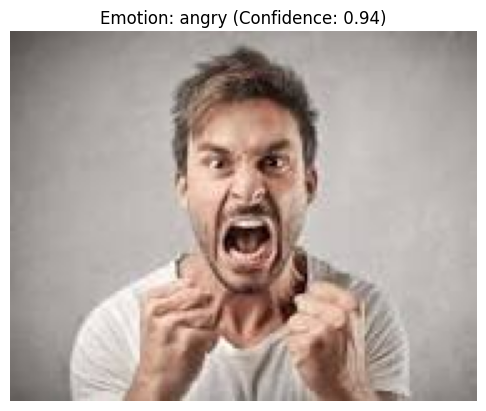

In [ ]:
main_predictions('/content/test_image1.jpeg')

Processing Audio...

=== Audio Preprocessing: /content/harvard.wav ===
Audio loaded: Sample rate = 44100, shape = (809508,)
MFCCs shape: (13, 1582)


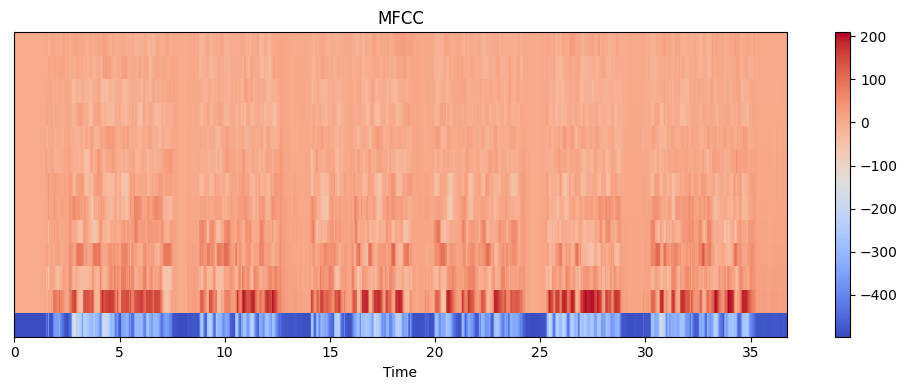

Spectrogram shape: (128, 1582)


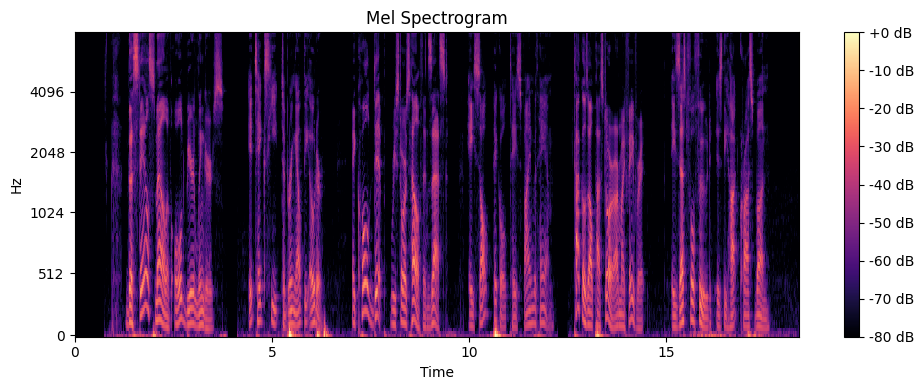

AttributeError: 'int' object has no attribute 'Recognizer'

In [ ]:
main_preprocess('/content/harvard.wav')

Processing Video...

=== Video Preprocessing: /content/sample_video2.mp4 ===
Extracted and preprocessed 886 frames.


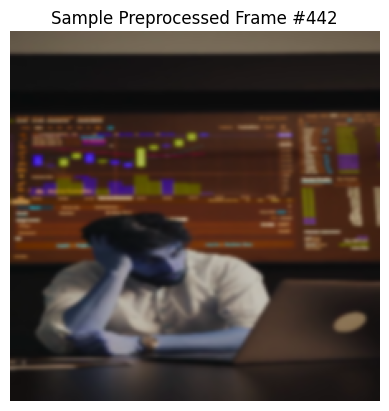

No audio track detected in video.


In [ ]:
main_preprocess('/content/sample_video2.mp4')

In [ ]:
main_preprocess('/content/test_image1.jpeg')

In [ ]:
main_preprocess(text_input="i ate 18 apples and today is a rainy day i am riding a bicycle, carrying an umbrella")

Processing Text...

=== Text Preprocessing ===
Original Text: i ate 18 apples and today is a rainy day i am riding a bicycle, carrying an umbrella
Processed Tokens: ['ate', '18', 'apple', 'today', 'rainy', 'day', 'riding', 'bicycle', 'carrying', 'umbrella']


['ate',
 '18',
 'apple',
 'today',
 'rainy',
 'day',
 'riding',
 'bicycle',
 'carrying',
 'umbrella']